<a href="https://colab.research.google.com/github/jvallalta/ia3/blob/main/1_RNNcell_PT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---

#<strong><center>Construcción de RNNs es con PyTorch y Google Colab</center></strong>
En este cuaderno, vamos a estudiar cómo construir una red neuronal recurrente (RNN) con una sola capa, que inicialmente consiste en una sola neurona, con PyTorch y Google Colab. Trasladaremos el concepto de una sola neurona recurrente a una célula de neuronas recurrentes en una sola capa y cómo implementar un modelo simple basado en RNN para la clasificación de imágenes.

Este trabajo está fuertemente inspirado en el libro de Aurélien Géron llamado ["Hand-On Machine Learning with Scikit-Learn and TensorFlow"](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/). Aunque sus implementaciones de redes neuronales son puramente en TensorFlow, se han adoptado algunas notaciones/nombres de variables e implementado usando sólo PyTorch. Es un gran su libro y resulta ideal para aprender bien sobre este tema, por lo que recomiendo encarecidamente el libro.

Vamos a utilizar Google Colab por lo que necesitamos instalar manualmente la biblioteca PyTorch primero. Puedes hacerlo usando el siguiente comando:

In [2]:
!pip3 install torch torchvision

Ahora ya podemos realizar la importación de modulos necesarios:

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

### RNN con una sola neurona


La idea de este tutorial es mostrarte las operaciones básicas necesarias para construir una arquitectura RNN usando PyTorch. En este punto se asume que tienes conocimientos de RNNs básicas, al menos de forma teorica.

En primer lugar, vamos a construir el gráfico de cálculo para una RNN de una sola capa. No nos preocupamos por las matemáticas por ahora, sólo vamos a centrarnos en las operaciones de PyTorch necesarias para construir los modelos RNN.

A modo de ilustración, esta es la arquitectura que estamos construyendo:

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vQXBLYvvI1dqAHdLA0hQdsP1PojmCfuSCMK2DXEL0uTvRUqvD1eYK8fsECcNCoekxCbgWJ-k7QF_1s4/pub?w=600&h=400)

Y el código:

In [5]:
class SingleRNN(nn.Module):
    def __init__(self, n_inputs, n_neurons):
        super(SingleRNN, self).__init__()
        
        self.Wx = torch.randn(n_inputs, n_neurons) # 4 X 1
        self.Wy = torch.randn(n_neurons, n_neurons) # 1 X 1
        
        self.b = torch.zeros(1, n_neurons) # 1 X 4
        
    def forward(self, X0, X1):
        self.Y0 = torch.tanh(torch.mm(X0, self.Wx) + self.b) # 4 X 1
        
        self.Y1 = torch.tanh(torch.mm(self.Y0, self.Wy) +
                            torch.mm(X1, self.Wx) + self.b) # 4 X 1
        
        return self.Y0, self.Y1

En el código anterior, se ha implementado una simple RNN de una capa y una neurona. Se han inicializado dos matrices de pesos, `Wx` y `Wy` con valores de una distribución normal. `Wx` contiene los pesos de conexión para las entradas del paso de tiempo actual, mientras que `Wy` contiene los pesos de conexión para las salidas del paso de tiempo anterior. Añadimos un sesgo `b`. La función `forward` calcula dos salidas - una para cada paso de tiempo... dos en este caso. Teng en cuenta que estamos utilizando `tanh` como la no linealidad (función de activación).

En cuanto a la entrada, estamos proporcionando 4 instancias, con cada instancia que contiene dos secuencias de entrada.

A modo de ilustración, así es como se introducen los datos en el modelo RNN: 

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vRpQYtOzO1U_3yQLf1885kMaja6MsXtJ8QnlqxrfpTgZmb4WpewJXphGdmotYXDB1VE6zlW6cBY_WqR/pub?w=600&h=600)

Y este el código para testear el modelo:

In [7]:
N_INPUT = 4
N_NEURONS = 1

X0_batch = torch.tensor([[0,1,2,0], [3,4,5,0], 
                         [6,7,8,0], [9,0,1,0]],
                        dtype = torch.float) #t=0 => 4 X 4

X1_batch = torch.tensor([[9,8,7,0], [0,0,0,0], 
                         [6,5,4,0], [3,2,1,0]],
                        dtype = torch.float) #t=1 => 4 X 4

model = SingleRNN(N_INPUT, N_NEURONS)

Y0_val, Y1_val = model(X0_batch, X1_batch)

Después de haber introducido la entrada en el gráfico de cálculo, obtenemos salidas para cada paso de tiempo (`Y0`, `Y1`), que ahora podemos imprimir como sigue:

In [ ]:
print(Y0_val)
print(Y1_val)

tensor([[-0.5958],
        [-0.8295],
        [-0.9337],
        [ 0.9680]])
tensor([[-0.6494],
        [ 0.0534],
        [-0.2475],
        [ 0.1238]])


### Aumentar las neuronas en la capa RNN
A continuación, veremos cómo generalizar la RNN que acabamos de construir para que la capa única soporte una `n` cantidad de neuronas. En términos de la arquitectura, nada cambia realmente ya que hemos parametrizado el número de neuronas en el gráfico de cálculo que hemos construido. Sin embargo, el tamaño de la salida cambia ya que hemos cambiado el tamaño del número de unidades (es decir, neuronas) en la capa RNN. 

He aquí una ilustración de lo que vamos a construir:

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vQov6BGg1fXOb7Bg5zenPh7R5j6VsZJh_D6JevQ_sm_fCxmXORxad3qLIFGG1FojzJig0qdcAQoGYoN/pub?w=600&h=404)

Y el código:

In [8]:
class BasicRNN(nn.Module):
    def __init__(self, n_inputs, n_neurons):
        super(BasicRNN, self).__init__()
        
        self.Wx = torch.randn(n_inputs, n_neurons) # n_inputs X n_neurons
        self.Wy = torch.randn(n_neurons, n_neurons) # n_neurons X n_neurons
        
        self.b = torch.zeros(1, n_neurons) # 1 X n_neurons
    
    def forward(self, X0, X1):
        self.Y0 = torch.tanh(torch.mm(X0, self.Wx) + self.b) # batch_size X n_neurons
        
        self.Y1 = torch.tanh(torch.mm(self.Y0, self.Wy) +
                            torch.mm(X1, self.Wx) + self.b) # batch_size X n_neurons
        
        return self.Y0, self.Y1

In [9]:
N_INPUT = 3 # number of features in input
N_NEURONS = 5 # number of units in layer

X0_batch = torch.tensor([[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        dtype = torch.float) #t=0 => 4 X 3

X1_batch = torch.tensor([[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]],
                        dtype = torch.float) #t=1 => 4 X 3

model = BasicRNN(N_INPUT, N_NEURONS)

Y0_val, Y1_val = model(X0_batch, X1_batch)

Ahora cuando imprimimos las salidas producidas para cada paso de tiempo, es de tamaño (`4 X 5`), que representa el tamaño del lote y el número de neuronas, respectivamente.

In [10]:
print(Y0_val)
print(Y1_val)

tensor([[-0.7165,  0.3600, -0.8273,  0.6142, -0.9570],
        [-0.9334, -0.7547, -1.0000, -0.7477, -0.9481],
        [-0.9857, -0.9818, -1.0000, -0.9901, -0.9375],
        [-0.6185,  0.5402, -1.0000, -1.0000,  0.9958]])
tensor([[-0.8913, -0.9994, -1.0000, -1.0000,  0.8548],
        [ 0.9419,  0.9921,  0.9723, -0.9954, -0.3357],
        [ 0.8898,  0.1007, -1.0000, -1.0000,  0.9547],
        [ 0.9948, -0.8365, -1.0000, -0.9985,  0.8772]])


### Célula RNN propia de PyTorch

Si observamos detenidamente el gráfico de cálculo `BasicRNN` que acabamos de construir, tiene un grave defecto. ¿Qué pasaría si quisiéramos construir una arquitectura que soportara entradas y salidas extremadamente grandes? La forma en que está construida actualmente, nos obligaría a calcular individualmente las salidas para cada paso de tiempo, aumentando las líneas de código necesarias para implementar el gráfico de cálculo deseado. A continuación vamos a ver como implementar esto de manera más eficiente y limpia utilizando el módulo incorporado RNNCell.

Primero vamos a intentar implementar esto de manera informal para analizar el papel que juega `RNCell`:

In [12]:
rnn = nn.RNNCell(3, 5) # n_input X n_neurons

X_batch = torch.tensor([[[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        [[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]]
                       ], dtype = torch.float) # X0 and X1

hx = torch.randn(4, 5) # m X n_neurons
output = []

# for each time step
for i in range(2):
    hx = rnn(X_batch[i], hx)
    output.append(hx)

print(output)

[tensor([[-0.2340, -0.0125, -0.4344,  0.1568,  0.8422],
        [-0.3440, -0.8864,  0.0913,  0.8135,  0.9975],
        [-0.7866, -0.9799,  0.6220,  0.9741,  1.0000],
        [-0.6414, -0.9786,  0.9060,  0.9961,  0.9959]], grad_fn=<TanhBackward>), tensor([[-0.4558, -0.9700,  0.9332,  0.9883,  1.0000],
        [ 0.7665,  0.2157, -0.3354,  0.0192,  0.2524],
        [ 0.6805, -0.9052,  0.7435,  0.9191,  0.9996],
        [ 0.8684, -0.5869,  0.3058,  0.6224,  0.9415]], grad_fn=<TanhBackward>)]


Con el código anterior, hemos implementado básicamente el mismo modelo que se implementó en `BasicRNN`. El código `torch.RNCell(...)` hace toda la "magia" de crear y mantener los pesos y sesgos necesarios para nosotros. `Torch.RNNCell` acepta un tensor como entrada y da como resultado el siguiente estado oculto para cada elemento del lote. Lee más sobre este módulo [aquí](https://pytorch.org/docs/stable/nn.html?highlight=rnncell#torch.nn.RNNCell).

Ahora, vamos a definir la función usando la misma información que usamos anteriormente.

In [13]:
class CleanBasicRNN(nn.Module):
    def __init__(self, batch_size, n_inputs, n_neurons):
        super(CleanBasicRNN, self).__init__()
        
        self.rnn = nn.RNNCell(n_inputs, n_neurons)
        self.hx = torch.randn(batch_size, n_neurons) # initialize hidden state
        
    def forward(self, X):
        output = []

        # for each time step
        for i in range(2):
            self.hx = self.rnn(X[i], self.hx)
            output.append(self.hx)
        
        return output, self.hx

In [14]:
FIXED_BATCH_SIZE = 4 # our batch size is fixed for now
N_INPUT = 3
N_NEURONS = 5

X_batch = torch.tensor([[[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        [[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]]
                       ], dtype = torch.float) # X0 and X1


model = CleanBasicRNN(FIXED_BATCH_SIZE, N_INPUT, N_NEURONS)
output_val, states_val = model(X_batch)
print(output_val) # contains all output for all timesteps
print(states_val) # contain values for final state or final timestep, i.e., t=1

[tensor([[ 0.8987,  0.5421,  0.6307, -0.3965, -0.2838],
        [ 0.4784, -0.1005,  0.9838, -0.8690,  0.9398],
        [ 0.9601, -0.6768,  0.9998, -0.9658,  0.9836],
        [-0.9675, -0.9944,  0.9882,  0.8519,  0.4850]], grad_fn=<TanhBackward>), tensor([[ 0.7521, -0.9858,  1.0000, -0.9850,  0.9984],
        [ 0.2153,  0.4893, -0.1541, -0.2618, -0.3149],
        [ 0.5337, -0.9302,  0.9985, -0.8779,  0.9540],
        [-0.5926, -0.9351,  0.9654,  0.3914,  0.7838]], grad_fn=<TanhBackward>)]
tensor([[ 0.7521, -0.9858,  1.0000, -0.9850,  0.9984],
        [ 0.2153,  0.4893, -0.1541, -0.2618, -0.3149],
        [ 0.5337, -0.9302,  0.9985, -0.8779,  0.9540],
        [-0.5926, -0.9351,  0.9654,  0.3914,  0.7838]], grad_fn=<TanhBackward>)


Puedes ver cómo el código es mucho más limpio ya que no necesitamos operar explícitamente sobre los pesos como se muestra en el fragmento de código anterior -- todo se maneja implícita y adecuadamente por PyTorch en un segundo plano.

### RNN for Image Classification

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vSiMstqkE9hTYmhPD3KMeFRNNKYA2NnrCayahBOEL1TalRqaWF7rH8a7O-nP9c-mKOdZRsWtmAGZfNN/pub?w=969&h=368)

Ahora que ya sabemos construir una RNN simple desde cero y utilizando el módulo incorporado `RNCell` proporcionado en PyTorch, vamos a hacer algo más sofisticado y especial.

Vamos a intentar construir un clasificador de imágenes utilizando el conjunto de datos MNIST. El conjunto de datos MNIST consiste en imágenes que contienen números escritos a mano del 1 al 10. Esencialmente, queremos construir un clasificador para predecir los números mostrados por un conjunto de imágenes. Este conjunto de datos lo hemos empleado y probado con diferentes técnicas (regresión logistica y MLP) en sesiones anteriores. Aunque puede parecer extraño, las RNN se comportan realmente bien en esta tarea de clasificación de imágenes. Vamos a comprobarlo.

Además, también utilizaremos el módulo `RNN` en lugar del módulo `RNCell` ya que queremos generalizar el gráfico de cálculo para poder soportar también un `n` número de capas. Sólo utilizaremos una capa en el siguiente gráfico de cálculo, pero puedes experimentar con el código más adelante añadiendo más capas.

#### Importar el conjunto de datos 
Antes de construir el gráfico de cálculo basado en RNN, vamos a importar el conjunto de datos MNIST, dividirlo en porciones de prueba y de entrenamiento, hacer algunas transformaciones y seguir explorándolo. 

Necesitarás las siguientes librerías PyTorch y líneas de código para descargar e importar el conjunto de datos MNIST a Google Colab.

In [15]:
import torchvision
import torchvision.transforms as transforms

In [16]:
BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


El código anterior carga y prepara el conjunto de datos para introducirlo en el gráfico de cálculo que construiremos más adelante. 

Tómate unos minutos para jugar con el código y entender lo que está sucediendo. Fíjate en que necesitamos proporcionar un tamaño de lote. Esto se debe a que `trainloader` y `testloader` son iteradores que harán más fácil cuando estemos iterando sobre el conjunto de datos y entrenando nuestro modelo RNN con minilotes.

#### Exploración del conjunto de datos
Aquí hay algunas líneas de código para explorar el conjunto de datos. No voy a cubrir mucho de lo que sucede aquí, pero puedes tomarte un tiempo y mirarlo por ti mismo..

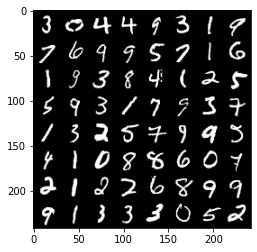

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

#### Modelo
Vamos a construir el gráfo de cálculo. A continuación, los parámetros:

In [18]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

 Y aquí el esquema de lo que vamos a construir

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vQWhELhewvq_bHgqwf4vwDb5B9DN9-jAxeTF9Y73zr-OsW6OXC-ngxAfojivXyZEhjzLXceTZU2Ncz3/pub?w=550&h=600)

Código para la clase que vamos a definir:

In [19]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        # rnn_out => n_steps, batch_size, n_neurons (hidden states for each time step)
        # self.hidden => 1, batch_size, n_neurons (final state from each lstm_out)
        rnn_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

El modelo `ImageRNN` hace lo siguiente:
- La función de inicialización `__init__(...)` declara algunas variables, y luego una capa RNN básica `basic_rnn` seguida de una capa totalmente conectada `self.FC`.
- La función `init_hidden` inicializa los pesos ocultos con valores cero. 
La función `forward` acepta una entrada de tamaño `n_pasos X tamaño_de_lote X n_neuronas`. A continuación, los datos pasan por la capa RNN y luego por la capa totalmente conectada. 
- La salida son las probabilidades logarítmicas del modelo.

#### Probar el modelo con algunas muestras
Una muy buena práctica alentada por los desarrolladores de PyTorch a lo largo de su documentación, y que realmente me gusta y recomiendo, es probar el modelo con una porción del conjunto de datos antes del entrenamiento real. Esto permite asegurar que tienes la dimensión correcta especificada y que el modelo está dando la información que esperas. 

Aquí vemos cómo probar el modelo:

In [20]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[-0.0654,  0.0702, -0.0080, -0.1534,  0.0052, -0.0442, -0.0055, -0.0428,
         -0.0603, -0.0113],
        [-0.0928,  0.0888,  0.0093, -0.1507,  0.0180, -0.0339,  0.0242, -0.0669,
         -0.0698,  0.0067],
        [-0.0771,  0.0849, -0.0231, -0.1572, -0.0019, -0.0382,  0.0136, -0.0402,
         -0.0600, -0.0291],
        [-0.0587,  0.0660, -0.0134, -0.1556,  0.0078, -0.0218, -0.0025, -0.0453,
         -0.0687, -0.0148],
        [-0.0790,  0.0754, -0.0163, -0.1445,  0.0079, -0.0251, -0.0004, -0.0455,
         -0.0556, -0.0100],
        [-0.1141,  0.0710,  0.0091, -0.1794,  0.0185, -0.0284,  0.0049, -0.0912,
         -0.0354,  0.0027],
        [-0.0714,  0.0760, -0.0032, -0.1584,  0.0065, -0.0513,  0.0029, -0.0437,
         -0.0593, -0.0127],
        [-0.0526,  0.0379, -0.0345, -0.2165, -0.0273, -0.0733, -0.0004, -0.0499,
         -0.0441, -0.0735],
        [-0.0743,  0.0767,  0.0012, -0.1535,  0.0056, -0.0475, -0.0003, -0.0442,
         -0.0561, -0.0113],
        [-0.0800,  

#### Entrenamiento

Ahora veamos el código para entrenar el modelo de clasificación de imágenes. Pero primero, vamos a declarar algunas funciones de ayuda necesarias para entrenar el modelo:

In [21]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

Antes de entrenar un modelo en PyTorch, se puede especificar programáticamente qué dispositivo se quiere utilizar durante el entrenamiento; la función `torch.device(...)` indica al programa que queremos utilizar la GPU si hay una disponible, de lo contrario la CPU será el dispositivo por defecto.

A continuación creamos una instancia del modelo, `ImageRNN(...)`, con los parámetros adecuados. El criterio representa la función que utilizaremos para calcular la pérdida del modelo. La función `nn.CrossEntropyLoss()` básicamente aplica un log softmax seguido de una operación de pérdida de log likelihood negativa sobre la salida del modelo. Para calcular la pérdida, la función necesita tanto las probabilidades logarítmicas como los objetivos. Veremos más adelante en nuestro código cómo proporcionar esto al criterio.

Para el entrenamiento, también necesitamos un algoritmo de optimización que ayude a actualizar los pesos basándose en la pérdida actual. Esto se consigue con la función de optimización `optim.Adam`, que requiere los parámetros del modelo y una tasa de aprendizaje. También se puede utilizar `optim.SGD` o cualquier otro algoritmo de optimización que esté disponible. 

La función `get_accuracy(...)` simplemente calcula la precisión del modelo dadas las probabilidades logarítmicas y los valores objetivo. Como ejercicio, puedes escribir código para probar esta función como hicimos antes con el modelo.

Vamos a ponerlo todo junto y a entrenar nuestro nuevo modelo para clasificación de imágenes:

In [22]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.7747 | Train Accuracy: 74.19
Epoch:  1 | Loss: 0.3676 | Train Accuracy: 89.12
Epoch:  2 | Loss: 0.2465 | Train Accuracy: 92.95
Epoch:  3 | Loss: 0.1981 | Train Accuracy: 94.37
Epoch:  4 | Loss: 0.1664 | Train Accuracy: 95.36
Epoch:  5 | Loss: 0.1497 | Train Accuracy: 95.75
Epoch:  6 | Loss: 0.1376 | Train Accuracy: 96.17
Epoch:  7 | Loss: 0.1247 | Train Accuracy: 96.50
Epoch:  8 | Loss: 0.1180 | Train Accuracy: 96.69
Epoch:  9 | Loss: 0.1137 | Train Accuracy: 96.81


Tenemos que calcular la precisión en el conjunto de datos de prueba para comprobar el rendimiento del modelo en la tarea de clasificación de imágenes. Como se puede ver a continuación, nuestro modelo RNN funciona muy bien en la tarea de clasificación MNIST.

In [23]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 96.62


### Observaciones finales
Tenga en cuenta que no hemos utilizado la GPU en este tutorial ya que los modelos que estamos construyendo son relativamente simples. 

Como ejercicio, puedes echar un vistazo a la [documentación de PyTorch](https://pytorch.org/docs/stable/notes/cuda.html) para revisar como programar operaciones específicas para que se ejecuten en la GPU. A continuación, puedes intentar optimizar el código para que se ejecute en la GPU. 

Eso es todo para este documento. Enhorabuena. Ahora eres capaz de implementar una RNN básica en PyTorch y has aprendido a aplicar las RNN para resolver un problema de clasificación de imágenes del mundo real.

### Referencies
- [A Simple Neural Network from Scratch with PyTorch and Google Colab](https://github.com/omarsar/pytorch_intro_neural_network/blob/master/nn.ipynb)
- [Hands on Machine Learning with Scikit-learn and Tensorflow](http://shop.oreilly.com/product/0636920052289.do)

##Fin del Notebook